# Polynomial Regression from scratch
During this experiment, we will see how to implement polynomial regression from scratch using Pytorch.

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### Generate a polynomial distribution with random noise

In [4]:
# Defining the range of our distribution
X = torch.tensor([i for i in range(-30, 30)]).float()

In [5]:
# Function for creating a vector with value between [r1, r2]
def randvec(r1, r2, shape):
    return (r1 - r2) * torch.rand(shape) + r2

In [6]:
# Creating random points from a gaussian with random noise
y = randvec(-1e4, 1e4, X.shape) - (1/2) * X + 3 * X.pow(2) - (6/4) * X.pow(3)

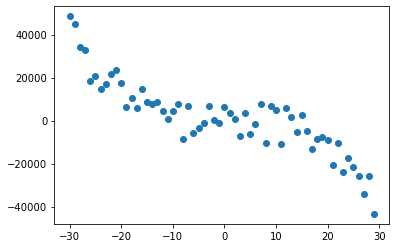

In [7]:
plt.scatter(X, y)

### Create the polynomial features
The formula of linear regression is as follow:<br>
$$
    \large \boldsymbol{\hat{y}} = \boldsymbol{X}\boldsymbol{w}
$$<br>
where $\boldsymbol{\hat{y}}$ is the target, $\boldsymbol{w}$ are the weights learned by the model and $\boldsymbol{X}$ is training data.<br>
Polynomial regression is still considered as a linear regression because there is only linear learning parameters:<br>
$$
    \large \boldsymbol{y} = \boldsymbol{w}_0 + \boldsymbol{X}\boldsymbol{w}_1 + \boldsymbol{X}^2\boldsymbol{w}_2 + \dots + \boldsymbol{X}^n\boldsymbol{w}_n
$$<br>
As you have probably guessed, this equation is not linear. We use a trick to make it linear:
- We gather all the $\boldsymbol{X}^2$ to $\boldsymbol{X}^n$ as new features that we created and we concatenate them to $\boldsymbol{X}$.
- All the $\boldsymbol{w}_1$ to $\boldsymbol{w}_n$ are concatenated to $\boldsymbol{w}_0$.<br>

At the end, the polynomial regression has the same formula as the linear regression but with the aggregated arrays.

In [8]:
def create_features(X, degree=2, standardize=True):
    """Creates the polynomial features
    
    Args:
        X: A torch tensor for the data.
        degree: A intege for the degree of the generated polynomial function.
        standardize: A boolean for scaling the data or not.
    """
    if len(X.shape) == 1:
        X = X.unsqueeze(1)
    # Concatenate a column of ones to has the bias in X
    ones_col = torch.ones((X.shape[0], 1), dtype=torch.float32)
    X_d = torch.cat([ones_col, X], axis=1)
    for i in range(1, degree):
        X_pow = X.pow(i + 1)
        # If we use the gradient descent method, we need to
        # standardize the features to avoid exploding gradients
        if standardize:
            X_pow -= X_pow.mean()
            std = X_pow.std()
            if std != 0:
                X_pow /= std
        X_d = torch.cat([X_d, X_pow], axis=1)
    return X_d

In [9]:
features = create_features(X, degree=3, standardize=False)

In [10]:
def predict(features, weights):
    return features.mm(weights)

In [11]:
y_true = y.unsqueeze(1)

### Method 1: Normal equation
The first method is analytical and uses the normal equation.
Training a linear model using least square regression is equivalent to minimize the mean squared error:

$$
\begin{align}
\text{Mse}(\hat{y}, y) &= \frac{1}{n}\sum_{i=1}^{n}{||\hat{y}_i - y_i ||_{2}^{2}} \\
\text{Mse}(\hat{y}, y) &= \frac{1}{n}||\boldsymbol{X}\boldsymbol{w} - \boldsymbol{y} ||_2^2
\end{align}
$$

where $n$ is the number of samples, $\hat{y}$ is the predicted value of the model and $y$ is the true target.<br/>
The prediction $\hat{y}$ is obtained by matrix multiplication between the input $\boldsymbol{X}$ and the weights of the model $\boldsymbol{w}$.<br/>

Minimizing the $\text{Mse}$ can be achieved by solving the gradient of this equation equals to zero in regards to the weights $\boldsymbol{w}$:

$$
\begin{align}
\nabla_{\boldsymbol{w}}\text{Mse}(\hat{y}, y) &= 0 \\
(\boldsymbol{X}^\top \boldsymbol{X})^{-1}\boldsymbol{X}^\top \boldsymbol{y} &= \boldsymbol{w}
\end{align}
$$

For more information on how to find $\boldsymbol{w}$ please visit the section "Linear Least Squares" of this [link](https://en.wikipedia.org/wiki/Least_squares#:~:text=The%20linear%20least%2Dsquares%20problem,is%20similar%20in%20both%20cases).

In [12]:
def normal_equation(y_true, X):
    """Computes the normal equation
    
    Args:
        y_true: A torch tensor for the labels.
        X: A torch tensor for the data.
    """
    XTX_inv = (X.T.mm(X)).inverse()
    XTy = X.T.mm(y_true)
    weights = XTX_inv.mm(XTy)
    return weights

In [13]:
weights = normal_equation(y_true, features)

In [14]:
y_pred = predict(features, weights)

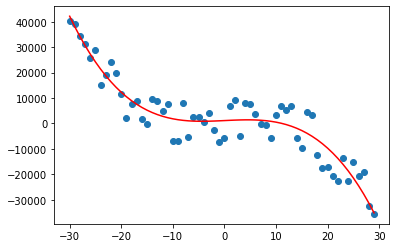

In [530]:
plt.scatter(X, y)
plt.plot(X, y_pred, c='red')

With the normal equation method, the polynomial regressor fits well the synthetic data.

### Method 2: Gradient Descent
 The Gradient descent method takes steps proportional to the negative of the gradient of a function at a given point, in order to iteratively minimize the objective function.<br> The gradient generalizes the notion of derivative to the case where the derivative is with respect to a vector: the gradient of $f$ is the vector containing all of the partial derivatives, denoted $\nabla_{\boldsymbol{x}}f(\boldsymbol{x})$.<br>
 
 The directional derivative in direction $\boldsymbol{u}$ (a unit vector) is the slope of the function $f$ in direction $\boldsymbol{u}$. In other words, the directional derivative is the derivative of the function $f(\boldsymbol{x} + \sigma \boldsymbol{u})$ with respect to $\sigma$ close to 0. To minimize $f$, we would like to find the direction in which $f$ decreases the fastest. We can do this using the directional derivative:
 $$\min_{\boldsymbol{u}, \boldsymbol{u}^\top \boldsymbol{u} = 1}{\boldsymbol{u}^\top \nabla_{\boldsymbol{x}} f(\boldsymbol{x})}$$<br>
 $$= \min_{\boldsymbol{u}, \boldsymbol{u}^\top \boldsymbol{u} = 1}{||\boldsymbol{u}||_2 ||\nabla_{\boldsymbol{x}}f(\boldsymbol{x})||_2 \cos \theta}$$<br>
ignoring factors that do not depend on $\boldsymbol{u}$, this simplifies to $\min_{u}{\cos \theta}$. This is minimized when $\boldsymbol{u}$ points in the opposite direction as the gradient. Each step of the gradient descent method proposes a new points:
$$\boldsymbol{x'} = \boldsymbol{x} - \epsilon \nabla_{\boldsymbol{x}}f(\boldsymbol{x})$$<br>
where $\epsilon$ is the learning rate.<br>
In the context of polynomial regression, the gradient descent is as follow:
$$\boldsymbol{w} = \boldsymbol{w} - \epsilon \nabla_{\boldsymbol{w}}\text{MSE}$$<br>
where:
$$\nabla_{\boldsymbol{w}}\text{MSE} = \nabla_{\boldsymbol{w}}\left(\frac{1}{n}{||\boldsymbol{X}\boldsymbol{w} - \boldsymbol{y} ||_2^2}\right)$$<br>
$$= \frac{2}{N}\boldsymbol{X}^\top(\boldsymbol{X}\boldsymbol{w} - \boldsymbol{y})$$

In [555]:
def gradient_descent(X, y_true, lr=0.001, it=30000):
    """Computes the gradient descent
    
    Args:
        X: A torch tensor for the data.
        y_true: A torch tensor for the labels.
        lr: A scalar for the learning rate.
        it: A scalar for the number of iteration
            or number of gradient descent steps.
    """
    weights_gd = torch.ones((X.shape[1], 1))
    n = X.shape[0]
    fact = 2 / n
    for _ in range(it):
        y_pred = predict(X, weights_gd)
        grad = fact * X.T.mm(y_pred - y_true)
        weights_gd -= lr * grad
    return weights_gd

In [532]:
features = create_features(X, degree=3, standardize=True)
weights_gd = gradient_descent(features, y_true)

In [533]:
pred_gd = predict(features, weights_gd)

In [554]:
print(mse(y_true, pred_gd))

tensor([[29417112.]])


The mean squared error is even lower when using gradient descent.

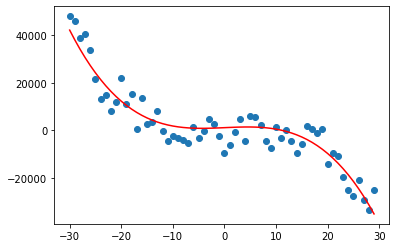

In [556]:
plt.scatter(X, y)
plt.plot(X, pred_gd, c='red')

### Conclusion
The polynomial regression is an appropriate example to visit both the concept of normal equation and gradient descent.<br>
This method work well for non-linear problems but we need to choose the right polynomial degree for a good bias/variance trade-off.